In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datasets/akshaydattatraykhare/diabetes-dataset/diabetes.csv


# **Answers to the questions :** 

### Section 1 :
**What does local interpretability in Explainable Artificial Intelligence (XAI) refer to?**
Understanding individual predictions or decisions made by the model

**Which of the following best describes accountability in the context of Trustworthy AI?**
The responsibility of the entities involved to ensure and answer for the outcomes produced by AI systems

### Section 2 :
Counterfactual explanations can be used to provide insights into model predictions. In a default prediction model, the dataset contains one row for each client. If a loan is denied but if the income was a few thousands euros higher and your age higher by 2 years, it would have been approved. We gain insight to be able to flip a prediction.

### Section 3 :
- We can use Post hoc Explainability to analyze feature importance for example to see which feature is the most important in the predictions. To see at which extent the model relies on these features, we can use explainability methods such as SHAP.
- We can see how the features push the model's prediction closer to the label being examined by analyzing SHAP values.
- We can also use LIME to understand the predictions of the model on certain examples. 

# **Training our models :**

In [2]:
# Loading the dataset
df_train = pd.read_csv("/kaggle/input/datasets/akshaydattatraykhare/diabetes-dataset/diabetes.csv")

print(df_train.shape)

(768, 9)


In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

In [4]:
# Extracting the label column
y = df_train['Outcome'].values.ravel()
df_train = df_train.drop('Outcome',axis=1)

In [5]:
# Function to apply transformations in training loop (to avoid data leakage)
def feature_engineering(df_train,df_val):
    scaler = StandardScaler()

    df_train = pd.DataFrame(scaler.fit_transform(df_train),columns=df_train.columns)
    df_val = pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)

    return df_train, df_val
    

## **Using 3 very simple models (interpretable) :**

In [6]:
# Used StratifiedKFold to train the model on samples with a similar distribution to our dataset

kfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=100)
cv_scores_naive = [] # List to store metric scores
cv_scores_logistic = []
cv_scores_lda = []

for i,(train_index,val_index) in enumerate(kfold.split(df_train,y)):
    X_train,X_val = df_train.iloc[train_index],df_train.iloc[val_index]
    y_train, y_val = y[train_index],y[val_index]

    X_train,X_val = feature_engineering(X_train,X_val) # Feature engineering on sample

    model_naive = GaussianNB()  # Naive Bayes Model
    model_logistic = LogisticRegression() # Logistic Regression Model
    model_lda = LinearDiscriminantAnalysis() # LDA Model

    model_naive.fit(X_train,y_train)
    model_logistic.fit(X_train,y_train)
    model_lda.fit(X_train,y_train)

    # Compute metrics (on both train and val samples)

    # Naive Bayes Model
    train_pred_naive = model_naive.predict_proba(X_train)[:,1]
    val_pred_naive = model_naive.predict_proba(X_val)[:,1]
    auc_score_train_naive = roc_auc_score(y_train,train_pred_naive)
    auc_score_val_naive = roc_auc_score(y_val,val_pred_naive)

    cv_scores_naive.append(auc_score_val_naive)
    
    # Logistic Regression Model
    train_pred_logistic = model_logistic.predict_proba(X_train)[:,1]
    val_pred_logistic = model_logistic.predict_proba(X_val)[:,1]
    auc_score_train_logistic = roc_auc_score(y_train,train_pred_logistic)
    auc_score_val_logistic = roc_auc_score(y_val,val_pred_logistic)

    cv_scores_logistic.append(auc_score_val_logistic)
    
    # LDA Model
    train_pred_lda = model_lda.predict_proba(X_train)[:,1]
    val_pred_lda = model_lda.predict_proba(X_val)[:,1]
    auc_score_train_lda = roc_auc_score(y_train,train_pred_lda)
    auc_score_val_lda = roc_auc_score(y_val,val_pred_lda)

    cv_scores_lda.append(auc_score_val_lda)


    print(f"Score for Naive Bayes model is :  TRAIN : {auc_score_train_naive} || VAL : {auc_score_val_naive} ")
    print(f"Score for Logistic Regression model is :  TRAIN : {auc_score_train_logistic} || VAL : {auc_score_val_logistic} ")
    print(f"Score for LDA model is :  TRAIN : {auc_score_train_lda} || VAL : {auc_score_val_lda} ")
    print("===================================================")

    
print(f"Mean AUC for Naive Bayes : {np.mean(cv_scores_naive)}")
print(f"Mean AUC for Logistic Regression : {np.mean(cv_scores_logistic)}")
print(f"Mean AUC for LDA : {np.mean(cv_scores_lda)}")
    
    

Score for Naive Bayes model is :  TRAIN : 0.8403417883334455 || VAL : 0.7914323962516734 
Score for Logistic Regression model is :  TRAIN : 0.8563715266097018 || VAL : 0.8044176706827308 
Score for LDA model is :  TRAIN : 0.8566070106977056 || VAL : 0.8028781793842034 
Score for Naive Bayes model is :  TRAIN : 0.8122032647172311 || VAL : 0.8178025970530848 
Score for Logistic Regression model is :  TRAIN : 0.8280067777274481 || VAL : 0.8511740563816187 
Score for LDA model is :  TRAIN : 0.8278557887496435 || VAL : 0.8527215232456435 
Score for Naive Bayes model is :  TRAIN : 0.825876155485094 || VAL : 0.8339500773733431 
Score for Logistic Regression model is :  TRAIN : 0.8426359320214069 || VAL : 0.8217721859651484 
Score for LDA model is :  TRAIN : 0.844682671498314 || VAL : 0.8229832469891677 
Mean AUC for Naive Bayes : 0.8143950235593671
Mean AUC for Logistic Regression : 0.8257879710098326
Mean AUC for LDA : 0.8261943165396715


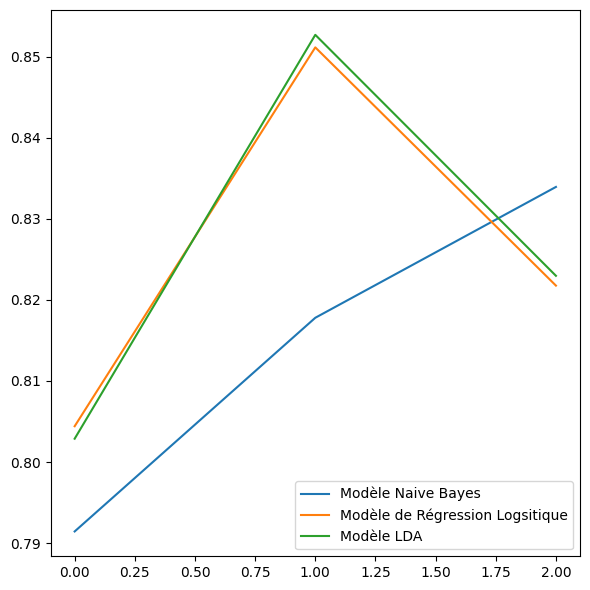

In [7]:
# We notice that the Naive Bayes model is the least performant which is 
# probably because of the assumptions made on the data

f,ax = plt.subplots(figsize=(6,6))
sns.lineplot(cv_scores_naive,ax=ax,label="Modèle Naive Bayes")
sns.lineplot(cv_scores_logistic,ax=ax,label="Modèle de Régression Logsitique")
sns.lineplot(cv_scores_lda,ax=ax,label = "Modèle LDA")

plt.tight_layout()

### **Interprétation de Naive Bayes :**

In [8]:
# Theta represents the mean of each feature, within each class
model_naive.theta_

array([[-0.15050798, -0.33525524, -0.03377363, -0.03224488, -0.0820377 ,
        -0.22996714, -0.11447963, -0.14713457],
       [ 0.27999529,  0.62368711,  0.06283028,  0.05998629,  0.15261761,
         0.42781597,  0.21297048,  0.27371961]])

In [9]:
# By computing the difference between each class, we can see the most predictive variables 
# (the ones that push the most the probabilities) which are Glucose and BMI in this case
model_naive.theta_[1] - model_naive.theta_[0]

array([0.43050327, 0.95894235, 0.09660391, 0.09223118, 0.23465531,
       0.65778311, 0.32745011, 0.42085418])

In [10]:
# Variance higher for diabetic, which means that it's harder to separate this group
model_naive.var_

array([[0.80826051, 0.6528722 , 0.91576883, 0.86397972, 0.79137054,
        0.94961531, 0.85425445, 1.00916204],
       [1.23616084, 1.04769409, 1.15062856, 1.24751072, 1.35230819,
        0.81232229, 1.20139838, 0.8677595 ]])

### **Interprétation du modèle de Régression Logistique :**

In [11]:
# Based on the coefficients, we notice that the most predictive variables are Glucose and BMI.
# They push the probabilities of diabetes. Age also pushes a little bit the probabilites but nothing
# too major. We can also see that the blood pressure affects the probabilities on the other side
model_logistic.coef_

array([[ 0.46572018,  1.09132027, -0.30960939, -0.11100299, -0.12931176,
         0.88342679,  0.26479073, -0.00413794]])

### **Interprétation du modèle de LDA :**

In [12]:
# We can see the same thing for the LDA model
model_lda.coef_

array([[ 0.48568411,  1.19610727, -0.34140019, -0.09183551, -0.15136172,
         0.83142439,  0.28291342, -0.00513758]])

## **Using a more complexe black box model (LGBM):**

In [13]:
params = {
    "objective": "binary",  # Binary classification problem
    "metric": "auc",  
    "num_threads" : -1,  
    "verbose" : -1,
    "lambda_l1":5  # Lasso regularisation to push some coefficients to 0
}

cv_scores = []
k_fold = StratifiedKFold(n_splits=3,shuffle=True,random_state=100)

for i, (train_index, val_index) in enumerate(k_fold.split(df_train, y)):
    X_train,X_val = df_train.iloc[train_index],df_train.iloc[val_index]
    y_train,y_val = y[train_index],y[val_index]
    
    train_data = lgb.Dataset(X_train,label=y_train)
    val_data = lgb.Dataset(X_val,label=y_val,reference = train_data)
    
    model = lgb.train(params,train_data,valid_sets=[val_data],callbacks=[lgb.early_stopping(stopping_rounds=50)])
    
    val_pred = model.predict(X_val,num_iteration=model.best_iteration)
    val_auc_lgb = roc_auc_score(y_val, val_pred)
    
    print(f" Le score de validation est de : {val_auc_lgb}")
    print("=====================")
    cv_scores.append(val_auc_lgb)



print(f"Mean AUC for lgbm is : {np.mean(cv_scores)}")
    

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.808768
 Le score de validation est de : 0.808768406961178
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.831629
 Le score de validation est de : 0.831628877077306
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's auc: 0.854269
 Le score de validation est de : 0.8542689901096683
Mean AUC for lgbm is : 0.8315554247160507


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

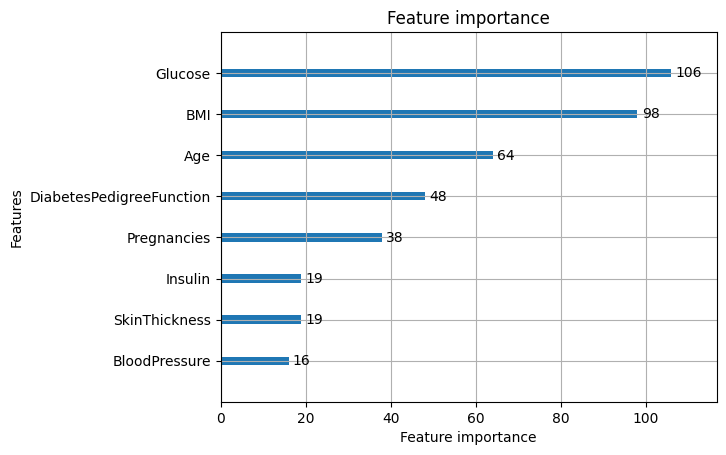

In [14]:
# We see that the AUC score is slightly higher for LGBM. However, this model is less interpretable. We
# can plot the feature importance to see the most predictive variables. We can also use SHAP and LIME.

lgb.plot_importance(model)

#The most predictive variables are always Glucose and BMI but also Age who has bigger influence on the
# prediction compared to less complexe models.

## **SHAP explanation :**

In [15]:
import shap
shap.initjs()

In [16]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_train)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Variable Importance Plot - Global Interpretation


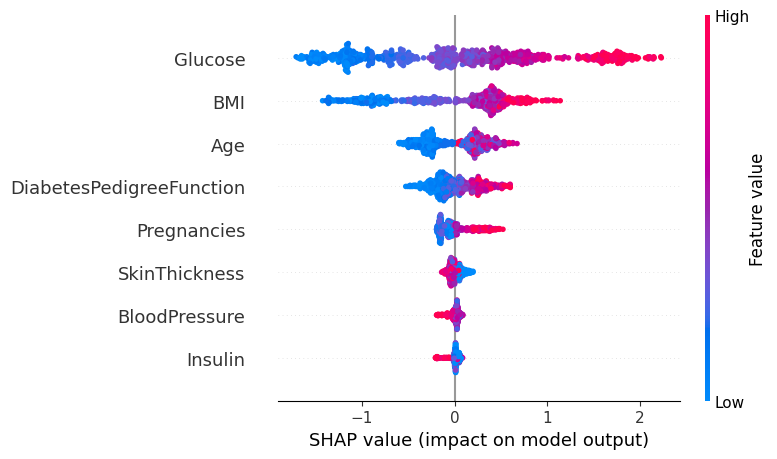

In [17]:
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, df_train)

#### **We see that the Glucose variable is the most predictive. If this variable is high, the patient is more likely to have diabetes. If it is low, the patient is less likely to have diabetes. We notice the same thing for the BMI variable. However, the variable Age is less predictive than the 2 other ones. The SHAP values are around 0, which means that the variable on its own cannot help the model predict correctly.**


In [18]:
shap_values[0]

array([ 0.02313495,  0.91442661,  0.027477  , -0.04029615,  0.05416142,
        0.4771734 ,  0.18499313,  0.30798201])

## **LIME explanation :**

In [19]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer

# Get the class names
class_names = ['No diabetes','Has diabetes']

# Get the feature names
feature_names = list(df_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(df_train.values, feature_names =     
                                 feature_names,
                                 class_names = class_names, 
                                 mode = 'classification')

In [20]:
# Selection of a data point in the dataset
predict_fn = lambda x: np.vstack((1 - model.predict(x), model.predict(x))).T
observation = df_train.iloc[1]

print(df_train.iloc[1])
print(f"Le label is : {y[1]}")

Pregnancies                  1.000
Glucose                     85.000
BloodPressure               66.000
SkinThickness               29.000
Insulin                      0.000
BMI                         26.600
DiabetesPedigreeFunction     0.351
Age                         31.000
Name: 1, dtype: float64
Le label is : 0


In [21]:
# Showing the lime interpretation
exp = explainer.explain_instance(observation, predict_fn,num_features=8)
exp.show_in_notebook(show_all=False)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

#### **We see that the model is 93% confident that the patient is not diabetic, which is mainly due to the glucose and bmi predictors. They pushed the predictions by respectively 29% and 22%. The model assumes that when glucose is below 99 and bmi under 27, the patient is less likely to be diabetic. The age has little to not impact.**

In [22]:
exp = explainer.explain_instance(df_train.iloc[17], predict_fn,num_features=8)
exp.show_in_notebook(show_all=False)

/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.12/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

#### **I chose this data point because it is very close to the boundaries of Glucose, BMI and Age chosen by our model. We can clearly see that the prediction is not confident at all (59% chance of being diabetic). This shows the limits of your model which can struggle to classify these patients around the boundaries.**

#### **If the model is not confident, it might predict false positives which can be problematic to solve a specific problem.**